# 💥 KModes Clustering in cardio data 💥

The dataset consists of 70 000 records of patients data in 12 features, such as age, gender, systolic blood pressure, diastolic blood pressure, and etc. The target class "cardio" equals to 1, when patient has cardiovascular desease, and it's 0, if patient is healthy.

The task is to predict the presence or absence of cardiovascular disease (CVD) using the patient examination results. 

#### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination. 


### KModes

KModes clustering is one of the unsupervised Machine Learning algorithms that is used to cluster **categorical variables**.

font: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/

***

# 1.1 Initial analysis
Let's look at the dataset and given variables.

## 1.2 Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import os
df = pd.read_csv("../input/cardio_train.csv",sep=";")

from kmodes.kmodes import KModes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.2 Cleaning Data

In [3]:
# General info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


All features are numerical, 12 integers and 1 decimal number (weight). The second column gives us an idea how big is the dataset and how many non-null values are there for each field. We can use `describe()` to display sample statistics such as `min`, `max`, `mean`,`std` for each attribute:

In [4]:
# Are there any `NA`s or missing values in a dataset?
df.isnull().values.any()

False

## 1.2.2 Removing Outliers

In [5]:
#removing Outliers
# Let's remove weights and heights, that fall below 2.5% or above 97.5% of a given range.
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

In [6]:
#In addition, in some cases diastolic pressure is higher than systolic, which is also  incorrect. How many records are inaccurate in terms of blood pressure?
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

Diastilic pressure is higher than systolic one in 1082 cases


In [7]:
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

In [8]:
#after removing outliers
df.describe()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,49895.698065,19468.719979,1.347311,164.554854,73.426805,125.770526,81.046307,1.350953,1.220229,0.085631,0.051877,0.803648,0.488228
std,28840.467755,2460.510296,0.476120,6.830174,11.614806,13.761847,8.239157,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866
min,0.000000,10798.000000,1.000000,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24867.500000,17677.250000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,49902.500000,19705.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74745.750000,21321.000000,2.000000,169.000000,80.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> Outliers removed and data cleaned
</p></div>

***

# 1.3 Transforming Data

## 1.3.1 Transforming the column AGE(measured in days) for Age_Bin

In [9]:
# transforming the column AGE(measured in days) for Years
df['years'] = (df['age'] / 365).round().astype('int')
df.drop(['age'], axis='columns', inplace=True)
df.drop(['id'], axis='columns', inplace=True)



In [10]:
# age_bin in quinquenium 5 years spam
df['age_bin'] = pd.cut(df['years'], [0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], 
                              labels=['0-20', '20-30', '30-35', '35-40','40-45','45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])

## 1.3.2 Transforming the column bmi in Body Mass Index Classes (1 to 6)

In [11]:
# Adding Body Mass Index
df['bmi'] = df['weight']/((df['height']/100)**2)

In [12]:
# transforming the column bmi in Body Mass Index Classes (1 to 6)
rating = []
for row in df['bmi']:
    if row < 18.5 :    rating.append(1) #UnderWeight
    elif row > 18.5 and row  < 24.9:   rating.append(2)#NormalWeight
    elif row > 24.9 and row < 29.9:  rating.append(3)#OverWeight
    elif row > 29.9 and row < 34.9:  rating.append(4)#ClassObesity_1
    elif row > 34.9 and row < 39.9:  rating.append(5)#ClassObesity_2
    elif row > 39.9 and row < 49.9:  rating.append(6)#ClassObesity_3
    elif row > 49.9:  rating.append('Error')
        
    else:           rating.append('Not_Rated')

In [13]:
# inserting Column
df['BMI_Class'] = rating


In [14]:
# general distribuition
df["BMI_Class"].value_counts(normalize=True)

3    0.391773
2    0.361943
4    0.179209
5    0.055801
6    0.009162
1    0.002112
Name: BMI_Class, dtype: float64

## 1.3.3 Creating the column MAP

Mean Arterial Pressure (MAP) = 2 Diastollic Blood Pressure + Sistolic Blood Pressure / 3

The overall blood pressure as measured in the brachial artery is maintained by the cardiac output and the total peripheral resistance (TPR) to flow. The mean arterial pressure (MAP) is calculated by the formula:


In [15]:
# creating a Column for MAP
df['MAP'] = ((2* df['ap_lo']) + df['ap_hi']) / 3

In [16]:
#Creating Classes for MAP
map_values = []
for row in df['MAP']:
    if row < 69.9:    map_values.append(1) #Low
    elif row > 70 and row  < 79.9:   map_values.append(2)#Normal
    elif row > 79.9 and row < 89.9:  map_values.append(3)#Normal
    elif row > 89.9 and row < 99.9:  map_values.append(4)#Normal
    elif row > 99.9 and row < 109.9:  map_values.append(5)#High
    elif row > 109.9 and row < 119.9:  map_values.append(6)#Normal
    elif row > 119.9:  map_values.append(7)
        
    else:           map_values.append('Not_Rated')

In [17]:
#inserting MAP_Class Column
df['MAP_Class'] = map_values

## 1.4 Reordering Columns

In [18]:
# Reordering Columns
df= df[["gender","height","weight","bmi","ap_hi","ap_lo","MAP","years","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio"]]
df.head()

,gender,height,weight,bmi,ap_hi,ap_lo,MAP,years,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,2,168,62.0,21.967120,110,80,90.000000,50,45-50,2,4,1,1,0,1,0
1,1,156,85.0,34.927679,140,90,106.666667,55,50-55,5,5,3,1,0,1,1
2,1,165,64.0,23.507805,130,70,90.000000,52,50-55,2,4,3,1,0,0,1
3,2,169,82.0,28.710479,150,100,116.666667,48,45-50,3,6,1,1,0,1,1
4,1,156,56.0,23.011177,100,60,73.333333,48,45-50,2,2,1,1,0,0,0


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> Columns MAP_Class, BMI_Class, years and age_bin added
</p></div>

***

# 2.1 Data Analize and Preparation

In [19]:
# only Categorical Data Columns DataFrame
df_cat = df[["gender","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio",]]

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)
df_cat.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,2,0,0,0,1,0
1,0,4,4,3,2,0,0,1,1
2,0,4,1,2,2,0,0,0,1
3,1,3,2,4,0,0,0,1,1
4,0,3,1,0,0,0,0,0,0


In [21]:
df_male = df_cat.query("gender == 0")
df_female = df_cat.query("gender == 1")
df_male.head()


,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,0,4,4,3,2,0,0,1,1
2,0,4,1,2,2,0,0,0,1
4,0,3,1,0,0,0,0,0,0
5,0,5,2,2,1,1,0,0,0
6,0,6,4,2,2,0,0,1,0


In [22]:
df_female.head()


,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,2,0,0,0,1,0
3,1,3,2,4,0,0,0,1,1
7,1,6,3,3,2,2,0,1,1
11,1,4,1,2,0,0,0,1,0
12,1,2,1,2,0,0,0,0,0


## 2.2 MAP Classes

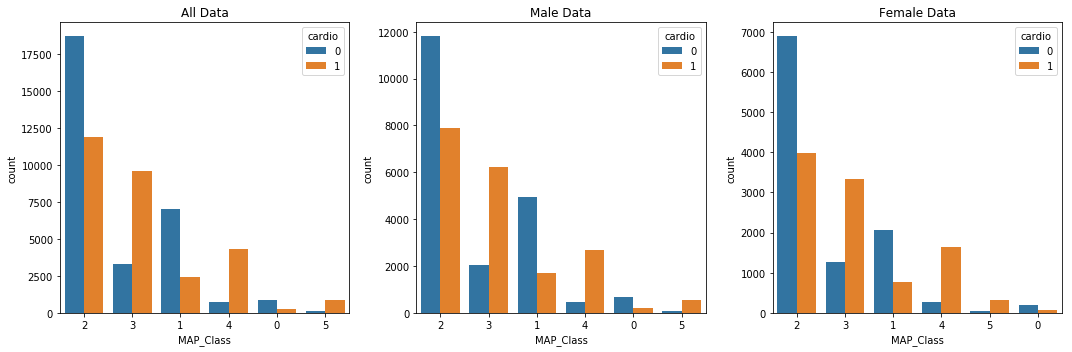

In [23]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['MAP_Class'],order=df_cat['MAP_Class'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['MAP_Class'],order=df_male['MAP_Class'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['MAP_Class'],order=df_female['MAP_Class'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> All the values are similar
</p></div>

## 2.3 BMI Classes

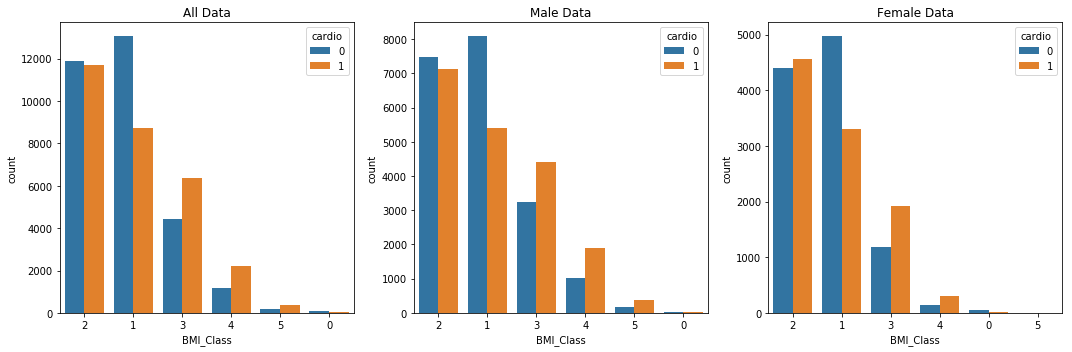

In [24]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['BMI_Class'],order=df_cat['BMI_Class'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['BMI_Class'],order=df_male['BMI_Class'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['BMI_Class'],order=df_female['BMI_Class'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> The BMI Classes for All data, Male and Female are very similar BUT the BMI_Class = 2 for Female data is slightly different
</p></div>

## 2.4 Glucose

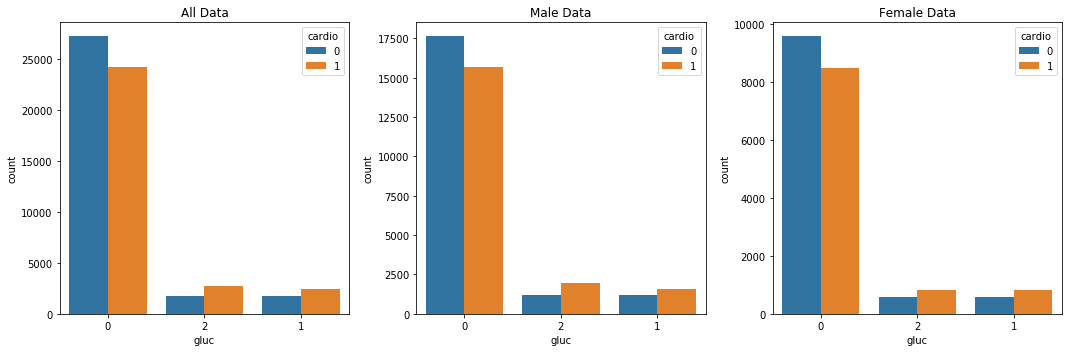

In [25]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['gluc'],order=df_cat['gluc'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['gluc'],order=df_male['gluc'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['gluc'],order=df_female['gluc'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> All the values are similar
</p></div>

## 2.5 Cholesterol

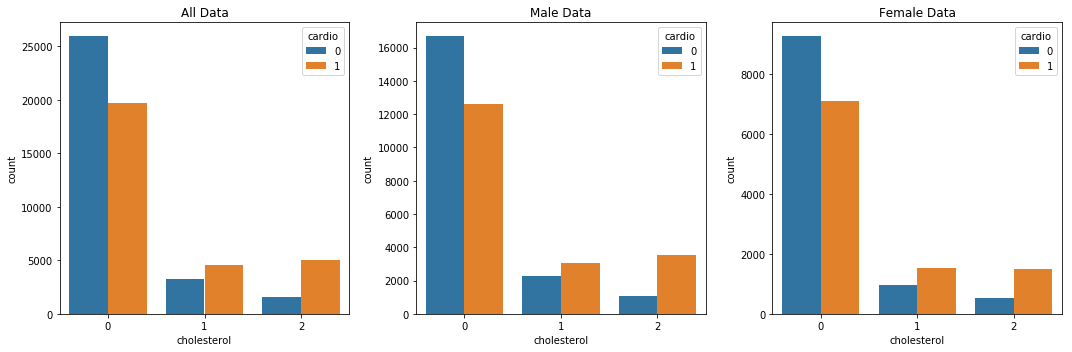

In [26]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['cholesterol'],order=df_cat['cholesterol'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['cholesterol'],order=df_male['cholesterol'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['cholesterol'],order=df_female['cholesterol'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> All the values are similar
</p></div>

## 2.6 Smoke

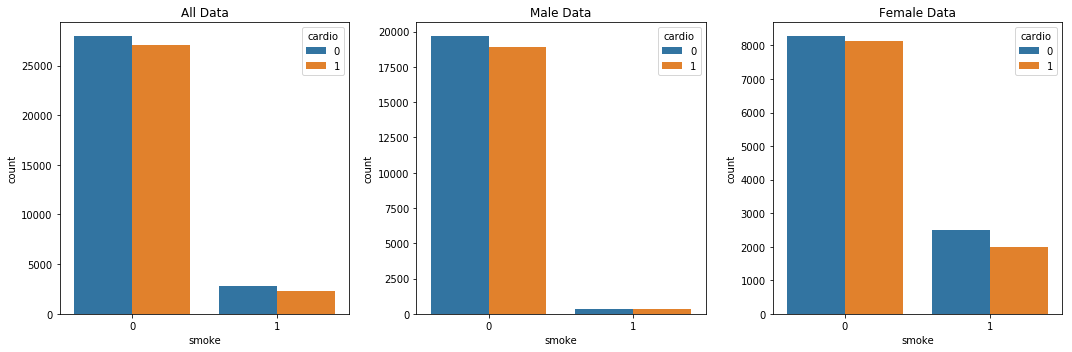

In [27]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['smoke'],order=df_cat['smoke'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['smoke'],order=df_male['smoke'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['smoke'],order=df_female['smoke'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> The value is high for Female data when smoke is 1
</p></div>

## 2.7 Active



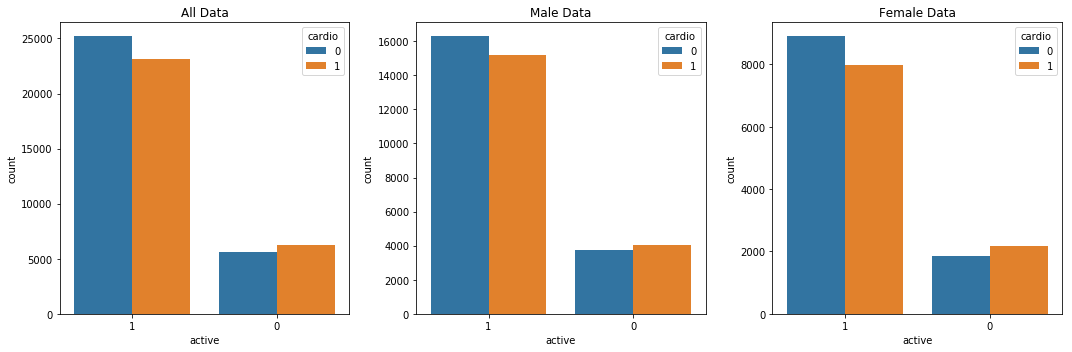

In [28]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['active'],order=df_cat['active'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['active'],order=df_male['active'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['active'],order=df_female['active'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> All the values are similar
</p></div>

## 2.8 Age


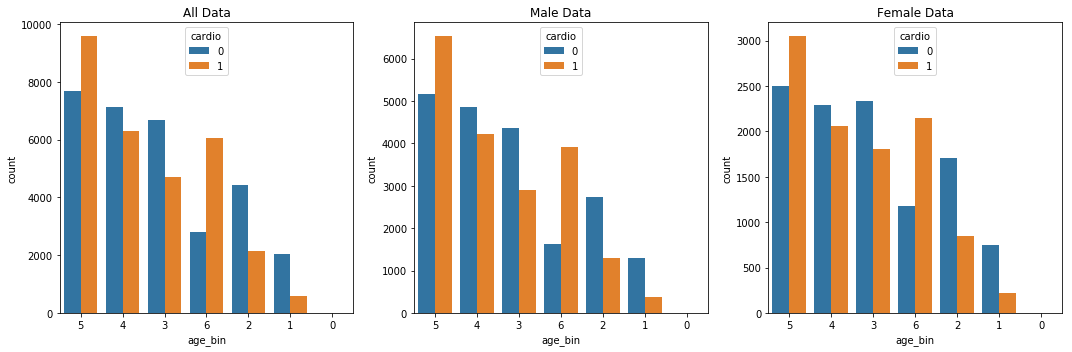

In [29]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['age_bin'],order=df_cat['age_bin'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['age_bin'],order=df_male['age_bin'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['age_bin'],order=df_female['age_bin'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> The datas are similar BUT in age_bin 6 (45-50 years) the values are very different 
    </p></div>

***

# 3.1 KModes Analisys

Thanks to : https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering

In [30]:
# new df to work
df_male = df_cat.query("gender == 0")
df_female = df_cat.query("gender == 1")

In [31]:
df_male.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,0,4,4,3,2,0,0,1,1
2,0,4,1,2,2,0,0,0,1
4,0,3,1,0,0,0,0,0,0
5,0,5,2,2,1,1,0,0,0
6,0,6,4,2,2,0,0,1,0


In [32]:
df_female.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,2,0,0,0,1,0
3,1,3,2,4,0,0,0,1,1
7,1,6,3,3,2,2,0,1,1
11,1,4,1,2,0,0,0,1,0
12,1,2,1,2,0,0,0,0,0


## 3.2 Elbow Curve Method

### 3.2.1 For All Data

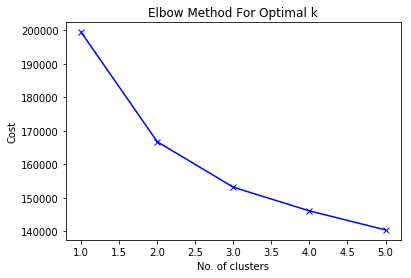

In [33]:
# Elbow curve to find optimal K in Huang init
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_cat)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

### 3.2.2 For Male Data

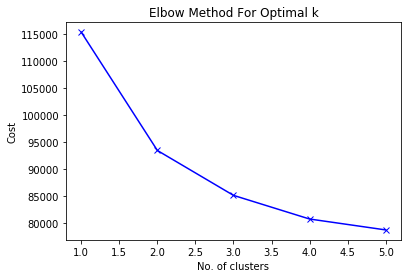

In [34]:
# Elbow curve to find optimal K in Huang
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_male)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

**The best number os clusters for male Data in Huang Init is 2**

### 3.2.3 For Female Data

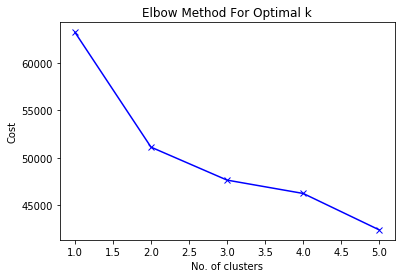

In [35]:
# Elbow curve to find optimal K
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_female)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

**The best number of clusters for female data is 2**

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> The best number of Clusters for All Data, Male and Female Data is 2 Clusters
</p></div>

## 2.3.1 Building a KModes for Data



In [36]:
# female data
# Building the model with using K-Mode with "Huang" initialization
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_1 = km_huang.fit_predict(df_female)
clusters_huang_1

array([1, 0, 0, ..., 0, 1, 1], dtype=uint8)

In [37]:
# male data
# Building the model with using K-Mode with "Huang" initialization
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_2 = km_huang.fit_predict(df_male)
clusters_huang_2

array([0, 1, 1, ..., 0, 0, 1], dtype=uint8)

## 2.3.2 Inserting clusters in DataFrame

In [38]:
df_female.insert(0,"Cluster", clusters_huang_1, True)

# female DataFrame with Clusters
df_female.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,1,3,1,2,0,0,0,1,0
3,0,1,3,2,4,0,0,0,1,1
7,0,1,6,3,3,2,2,0,1,1
11,1,1,4,1,2,0,0,0,1,0
12,1,1,2,1,2,0,0,0,0,0


In [39]:
df_male.insert(0, "Cluster", clusters_huang_2, True)

# female DataFrame with Clusters
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,0,0,4,4,3,2,0,0,1,1
2,1,0,4,1,2,2,0,0,0,1
4,1,0,3,1,0,0,0,0,0,0
5,1,0,5,2,2,1,1,0,0,0
6,1,0,6,4,2,2,0,0,1,0


In [40]:
# replacing cluster column values to merge dataframes after
df_male["Cluster"].replace({0:2, 1:3}, inplace=True)
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,2,0,4,4,3,2,0,0,1,1
2,3,0,4,1,2,2,0,0,0,1
4,3,0,3,1,0,0,0,0,0,0
5,3,0,5,2,2,1,1,0,0,0
6,3,0,6,4,2,2,0,0,1,0


In [41]:
# merging female and male data
df_clusters = pd.concat([df_female, df_male], ignore_index=True, sort=False)
df_clusters.head(10)

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,1,3,1,2,0,0,0,1,0
1,0,1,3,2,4,0,0,0,1,1
2,0,1,6,3,3,2,2,0,1,1
3,1,1,4,1,2,0,0,0,1,0
4,1,1,2,1,2,0,0,0,0,0
5,1,1,5,1,1,0,0,1,1,0
6,1,1,4,3,2,0,0,0,1,0
7,1,1,1,1,2,0,0,0,1,0
8,0,1,5,2,2,0,2,0,0,0
9,0,1,5,2,3,2,0,0,0,1


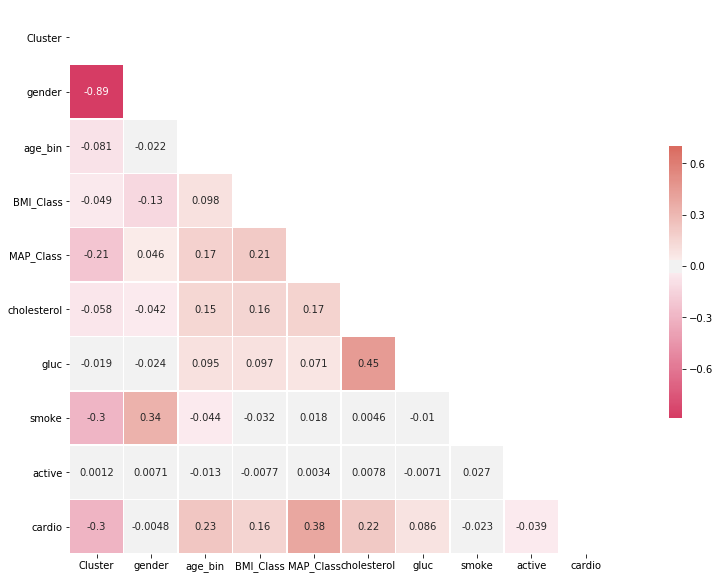

In [42]:
corr = df_clusters.corr()
cmap = sns.diverging_palette(2, 15, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## 2.4 Analizing Clusters



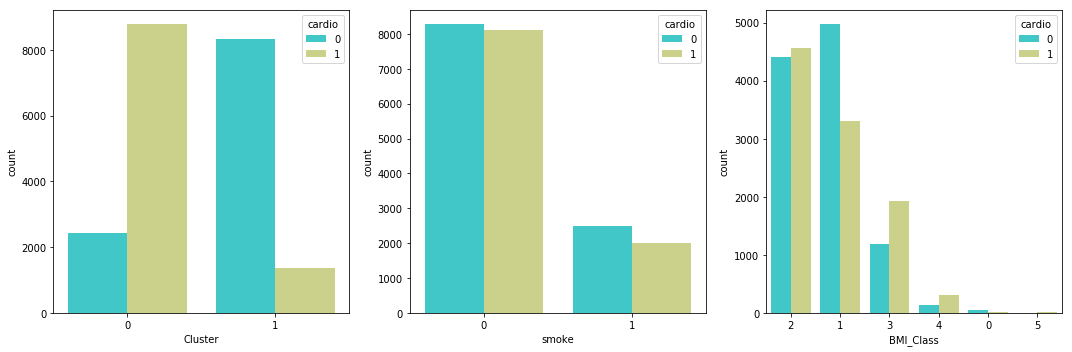

In [43]:
# female
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_female['Cluster'],order=df_female['Cluster'].value_counts().index,hue=df_female['cardio'],ax=axs[0],palette='rainbow')
sns.countplot(x=df_female['smoke'],order=df_female['smoke'].value_counts().index,hue=df_female['cardio'],ax=axs[1],palette='rainbow')
sns.countplot(x=df_female['BMI_Class'],order=df_female['BMI_Class'].value_counts().index,hue=df_female['cardio'],ax=axs[2],palette='rainbow')

plt.tight_layout()
plt.show()

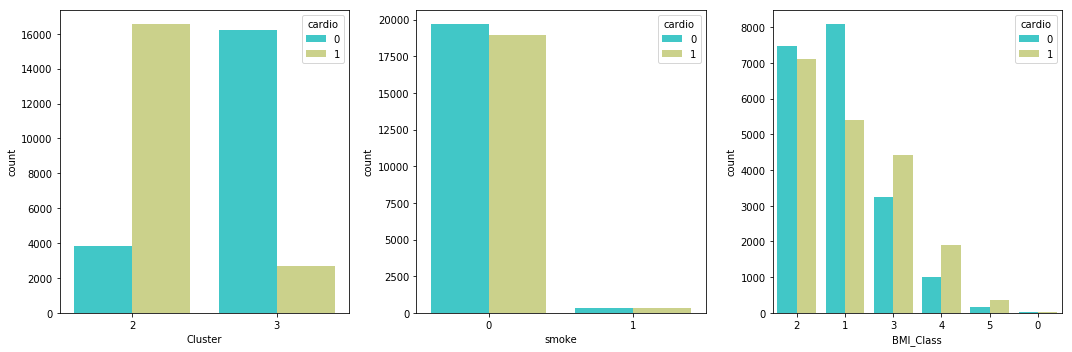

In [44]:
# male
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_male['Cluster'],order=df_male['Cluster'].value_counts().index,hue=df_male['cardio'],ax=axs[0],palette='rainbow')
sns.countplot(x=df_male['smoke'],order=df_male['smoke'].value_counts().index,hue=df_male['cardio'],ax=axs[1],palette='rainbow')
sns.countplot(x=df_male['BMI_Class'],order=df_male['BMI_Class'].value_counts().index,hue=df_male['cardio'],ax=axs[2],palette='rainbow')

plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> There are notably difference between clusters
</p></div>

### 2.4.1 For Female Data

In [45]:
# separating clusters
df_female_c0 = df_female[df_female["Cluster"] == 0]
df_female_c1 = df_female[df_female["Cluster"] == 1]


df_female_c0.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
3,0,1,3,2,4,0,0,0,1,1
7,0,1,6,3,3,2,2,0,1,1
29,0,1,5,2,2,0,2,0,0,0
34,0,1,5,2,3,2,0,0,0,1
38,0,1,6,2,2,0,0,1,1,1


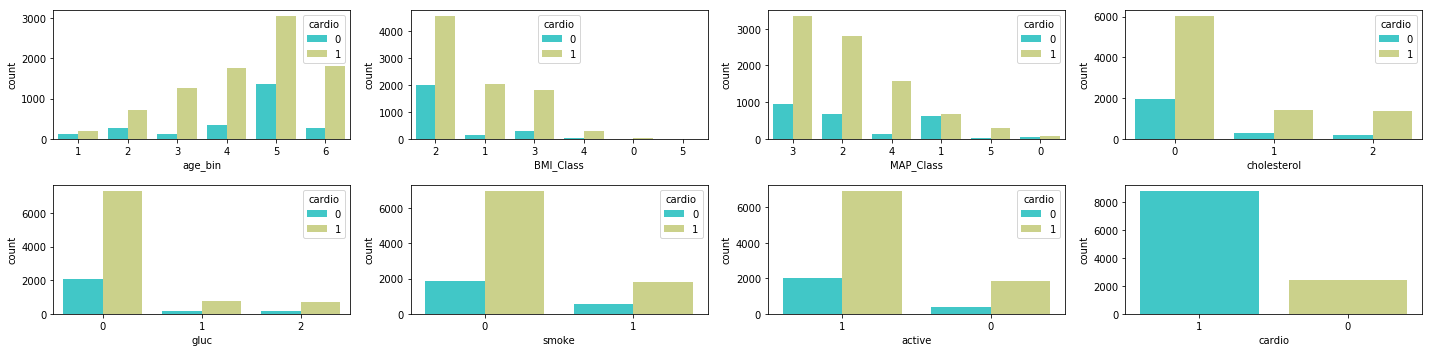

In [46]:
# for df_female_c0
f, axs = plt.subplots(2,4,figsize = (20,5))
sns.countplot(x=df_female_c0['age_bin'],hue=df_female_c0['cardio'],ax=axs[0,0],palette='rainbow')
sns.countplot(x=df_female_c0['BMI_Class'],order=df_female_c0['BMI_Class'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[0,1],palette='rainbow')
sns.countplot(x=df_female_c0['MAP_Class'],order=df_female_c0['MAP_Class'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[0,2],palette='rainbow')
sns.countplot(x=df_female_c0['cholesterol'],order=df_female_c0['cholesterol'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[0,3],palette='rainbow')
sns.countplot(x=df_female_c0['gluc'],order=df_female_c0['gluc'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[1,0],palette='rainbow')
sns.countplot(x=df_female_c0['smoke'],order=df_female_c0['smoke'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[1,1],palette='rainbow')
sns.countplot(x=df_female_c0['active'],order=df_female_c0['active'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[1,2],palette='rainbow')
sns.countplot(x=df_female_c0['cardio'],order=df_female_c0['cardio'].value_counts().index,ax=axs[1,3],palette='rainbow')

plt.tight_layout()
plt.show()


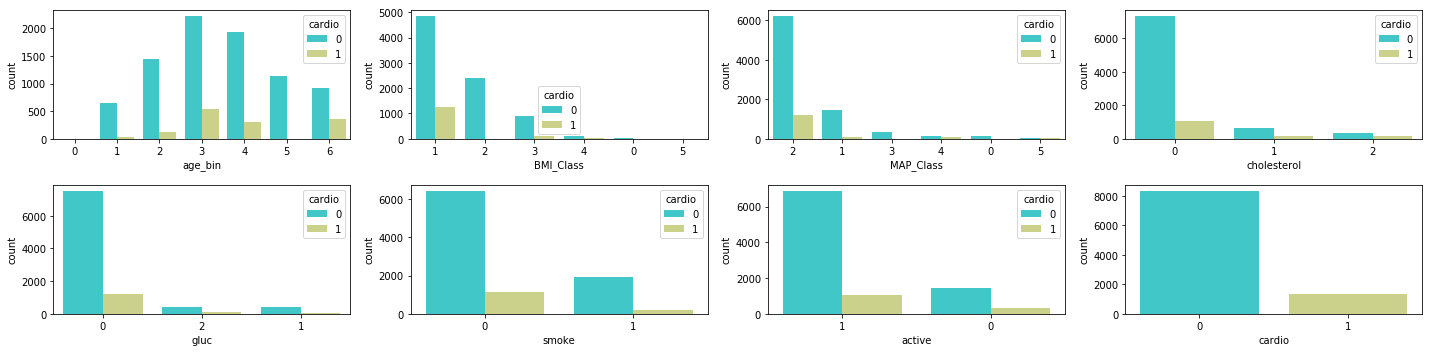

In [47]:
# for df_female_c1
f, axs = plt.subplots(2,4,figsize = (20,5))
sns.countplot(x=df_female_c1['age_bin'],hue=df_female_c1['cardio'],ax=axs[0,0],palette='rainbow')
sns.countplot(x=df_female_c1['BMI_Class'],order=df_female_c1['BMI_Class'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[0,1],palette='rainbow')
sns.countplot(x=df_female_c1['MAP_Class'],order=df_female_c1['MAP_Class'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[0,2],palette='rainbow')
sns.countplot(x=df_female_c1['cholesterol'],order=df_female_c1['cholesterol'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[0,3],palette='rainbow')
sns.countplot(x=df_female_c1['gluc'],order=df_female_c1['gluc'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[1,0],palette='rainbow')
sns.countplot(x=df_female_c1['smoke'],order=df_female_c1['smoke'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[1,1],palette='rainbow')
sns.countplot(x=df_female_c1['active'],order=df_female_c1['active'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[1,2],palette='rainbow')
sns.countplot(x=df_female_c1['cardio'],order=df_female_c1['cardio'].value_counts().index,ax=axs[1,3],palette='rainbow')

plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> BMI_Class, Smoke and Age_Bin are very different within female clusters
</p></div>

### 2.4.2For Male Data

In [48]:
# separating clusters
df_male_c2 = df_male[df_male["Cluster"] == 2]
df_male_c3 = df_male[df_male["Cluster"] == 3]


df_male_c2.describe()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
count,20371.0,20371.0,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000
mean,2.0,0.0,4.296009,2.373227,2.529724,0.512395,0.279220,0.018261,0.796966,0.811939
std,0.0,0.0,1.301995,0.913096,1.083884,0.772999,0.628711,0.133898,0.402267,0.390771
min,2.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.0,0.0,3.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,2.0,0.0,5.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,2.0,0.0,5.000000,3.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,2.0,0.0,6.000000,5.000000,5.000000,2.000000,2.000000,1.000000,1.000000,1.000000


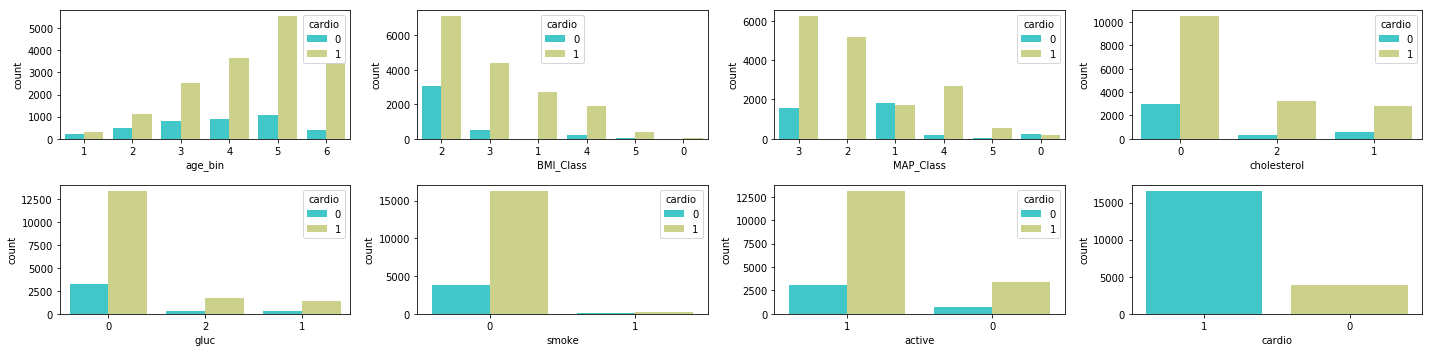

In [49]:
# for df_male_c2
f, axs = plt.subplots(2,4,figsize = (20,5))
sns.countplot(x=df_male_c2['age_bin'],hue=df_male_c2['cardio'],ax=axs[0,0],palette='rainbow')
sns.countplot(x=df_male_c2['BMI_Class'],order=df_male_c2['BMI_Class'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[0,1],palette='rainbow')
sns.countplot(x=df_male_c2['MAP_Class'],order=df_male_c2['MAP_Class'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[0,2],palette='rainbow')
sns.countplot(x=df_male_c2['cholesterol'],order=df_male_c2['cholesterol'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[0,3],palette='rainbow')
sns.countplot(x=df_male_c2['gluc'],order=df_male_c2['gluc'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[1,0],palette='rainbow')
sns.countplot(x=df_male_c2['smoke'],order=df_male_c2['smoke'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[1,1],palette='rainbow')
sns.countplot(x=df_male_c2['active'],order=df_male_c2['active'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[1,2],palette='rainbow')
sns.countplot(x=df_male_c2['cardio'],order=df_male_c2['cardio'].value_counts().index,ax=axs[1,3],palette='rainbow')

plt.tight_layout()
plt.show()

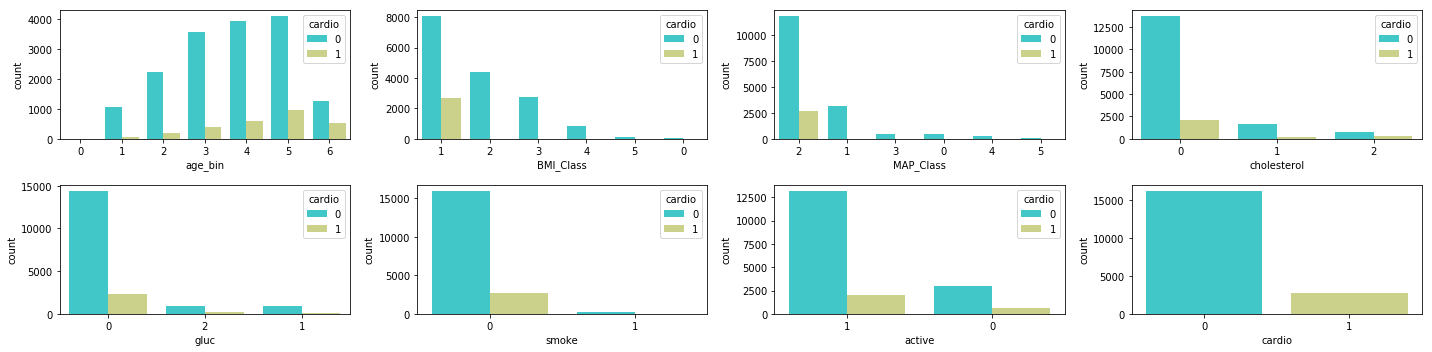

In [50]:
# for df_male_c3
f, axs = plt.subplots(2,4,figsize = (20,5))
sns.countplot(x=df_male_c3['age_bin'],hue=df_male_c3['cardio'],ax=axs[0,0],palette='rainbow')
sns.countplot(x=df_male_c3['BMI_Class'],order=df_male_c3['BMI_Class'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[0,1],palette='rainbow')
sns.countplot(x=df_male_c3['MAP_Class'],order=df_male_c3['MAP_Class'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[0,2],palette='rainbow')
sns.countplot(x=df_male_c3['cholesterol'],order=df_male_c3['cholesterol'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[0,3],palette='rainbow')
sns.countplot(x=df_male_c3['gluc'],order=df_male_c3['gluc'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[1,0],palette='rainbow')
sns.countplot(x=df_male_c3['smoke'],order=df_male_c3['smoke'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[1,1],palette='rainbow')
sns.countplot(x=df_male_c3['active'],order=df_male_c3['active'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[1,2],palette='rainbow')
sns.countplot(x=df_male_c3['cardio'],order=df_male_c3['cardio'].value_counts().index,ax=axs[1,3],palette='rainbow')

plt.tight_layout()
plt.show()

## 3.1 Dataframes from  Clusters Results

In [51]:
#list of columns
my_list = df_clusters.columns.values.tolist()
my_list

['Cluster',
 'gender',
 'age_bin',
 'BMI_Class',
 'MAP_Class',
 'cholesterol',
 'gluc',
 'smoke',
 'active',
 'cardio']

In [52]:
# function to calc % in column
def function(dataframe,valor):
    my_list = dataframe.columns.values.tolist()
    for x in my_list[2:]:
        for y in range(valor):
            percentages = round(((dataframe[x]== y) & (dataframe['cardio']== 1)).sum()/ (dataframe[x]== y).sum()* 100, 2)
            print(percentages)

In [53]:
# applying the function
# there must be a better way to do that though...
function(df_male_c3,8)

0.0
3.88
7.99
9.82
12.74
19.22
29.0
nan
0.0
25.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
18.58
0.0
0.0
0.0
nan
nan
13.35
12.81
29.98
nan
nan
nan
nan
nan
13.78
12.49
22.99
nan
nan
nan
nan
nan
14.38
7.22
nan
nan
nan
nan
nan
nan
17.25
13.55
nan
nan
nan
nan
nan
nan
0.0
100.0
nan
nan
nan
nan
nan
nan


In [54]:
# dictionary with list object in values
# placed by hand...
details = {
    'age_bin_0':[0.0, 0.0, 0.0, 0.0],
    'age_bin_1':[7.62, 92.44, 8.48, 100.0],
    'age_bin_2':[12.94, 92.46, 13.73, 100.0],
    'age_bin_3':[19.73, 92.21, 16.17, 100.0],
    'age_bin_4':[36.29, 100.0, 34.82, 100.0],
    'age_bin_5':[16.6, 84.63, 0.0, 76.59],
    'age_bin_6':[38.56, 93.29, 38.23, 100.0],
    
    'BMI_Class_0':[12.07, 100.0, 9.76, 100.0],
    'BMI_Class_1':[31.1, 100.0, 30.77, 100.0],
    'BMI_Class_2':[8.8, 86.34, 0.0, 78.11],
    'BMI_Class_3':[32.73, 94.86, 22.18, 100.0],
    'BMI_Class_4':[37.62, 94.29, 27.91, 100.0],
    'BMI_Class_5':[66.67, 100.0, 31.54, 100.0],
    
    'MAP_Class_0':[12.55, 85.71, 10.2, 70.29],
    'MAP_Class_1':[11.94, 75.34, 10.1, 75.49],
    'MAP_Class_2':[25.28, 100.0, 17.03, 82.55],
    'MAP_Class_3':[19.89, 85.49, 46.41, 94.35],
    'MAP_Class_4':[60.13, 97.42, 59.48, 97.17],
    'MAP_Class_5':[61.4, 95.04, 58.67, 97.95],
    
    'cholesterol_0':[22.06, 89.16, 18.84, 85.04],
    'cholesterol_1':[29.81, 92.4, 26.92, 90.33],
    'cholesterol_2':[48.41, 92.0, 44.38, 95.2],
    
    'gluc_0' : [23.69, 90.18, 20.78, 86.95],
    'gluc_1' : [28.45, 90.39, 24.72, 90.59],
    'gluc_2' : [31.87, 89.4, 31.12, 91.51],
    
    'smoke_0' : [25.93, 90.48, 21.73, 87.7],
    'smoke_1' : [18.9, 88.86, 19.49, 88.43],
    
    'active_0' : [29.93, 91.7, 24.19, 88.99],
    'active_1' : [23.16, 89.73, 21.1, 87.38],
}



In [55]:
# creating a Dataframe object from dictionary 
# with custom indexing
df_pc = pd.DataFrame(details, index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])
df_pc.head()


,age_bin_0,age_bin_1,age_bin_2,age_bin_3,age_bin_4,age_bin_5,age_bin_6,BMI_Class_0,BMI_Class_1,BMI_Class_2,BMI_Class_3,BMI_Class_4,BMI_Class_5,MAP_Class_0,MAP_Class_1,MAP_Class_2,MAP_Class_3,MAP_Class_4,MAP_Class_5,cholesterol_0,cholesterol_1,cholesterol_2,gluc_0,gluc_1,gluc_2,smoke_0,smoke_1,active_0,active_1
Cluster 0,0.0,7.62,12.94,19.73,36.29,16.60,38.56,12.07,31.10,8.80,32.73,37.62,66.67,12.55,11.94,25.28,19.89,60.13,61.40,22.06,29.81,48.41,23.69,28.45,31.87,25.93,18.90,29.93,23.16
Cluster 1,0.0,92.44,92.46,92.21,100.00,84.63,93.29,100.00,100.00,86.34,94.86,94.29,100.00,85.71,75.34,100.00,85.49,97.42,95.04,89.16,92.40,92.00,90.18,90.39,89.40,90.48,88.86,91.70,89.73
Cluster 2,0.0,8.48,13.73,16.17,34.82,0.00,38.23,9.76,30.77,0.00,22.18,27.91,31.54,10.20,10.10,17.03,46.41,59.48,58.67,18.84,26.92,44.38,20.78,24.72,31.12,21.73,19.49,24.19,21.10
Cluster 3,0.0,100.00,100.00,100.00,100.00,76.59,100.00,100.00,100.00,78.11,100.00,100.00,100.00,70.29,75.49,82.55,94.35,97.17,97.95,85.04,90.33,95.20,86.95,90.59,91.51,87.70,88.43,88.99,87.38


In [56]:
# creating separate dfs
df_agebins = df_pc.loc[:,"age_bin_0":"age_bin_6"]
df_bmi = df_pc.loc[:,"BMI_Class_0":"BMI_Class_5"]
df_map = df_pc.loc[:,"MAP_Class_0":"MAP_Class_5"]
df_chol = df_pc.loc[:,"cholesterol_0":"cholesterol_2"]
df_gluc = df_pc.loc[:,"gluc_0":"gluc_2"]
df_smokers = df_pc.loc[:,"smoke_0":"smoke_1"]
df_actives = df_pc.loc[:,"active_0":"active_1"]


## 4.1 Plotting Clusters

## 4.1.2 Age Bins

In [57]:
df_agebins.head()

,age_bin_0,age_bin_1,age_bin_2,age_bin_3,age_bin_4,age_bin_5,age_bin_6
Cluster 0,0.0,7.62,12.94,19.73,36.29,16.60,38.56
Cluster 1,0.0,92.44,92.46,92.21,100.00,84.63,93.29
Cluster 2,0.0,8.48,13.73,16.17,34.82,0.00,38.23
Cluster 3,0.0,100.00,100.00,100.00,100.00,76.59,100.00


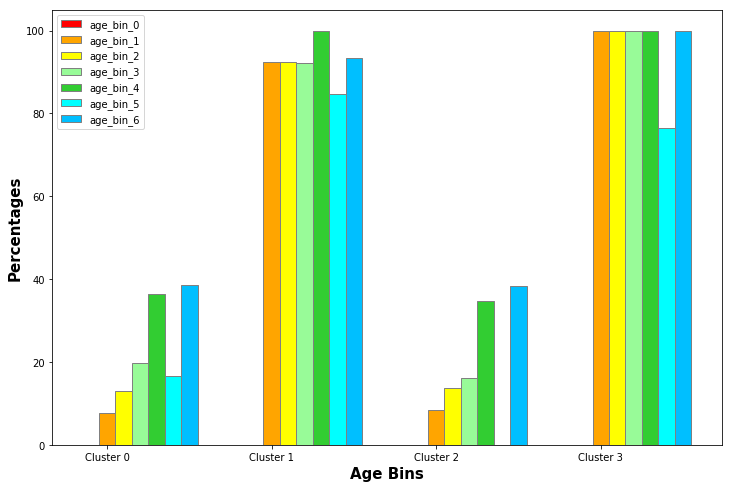

In [58]:
# set width of bar
barWidth = 0.10
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
age_bin_0 = df_agebins['age_bin_0']
age_bin_1 = df_agebins['age_bin_1']
age_bin_2 = df_agebins['age_bin_2']
age_bin_3 = df_agebins['age_bin_3']
age_bin_4 = df_agebins['age_bin_4']
age_bin_5 = df_agebins['age_bin_5']
age_bin_6 = df_agebins['age_bin_6']
 
# Set position of bar on X axis
br1 = np.arange(len(age_bin_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]
br7 = [x + barWidth for x in br6]


 # Make the plot
plt.bar(br1, age_bin_0, color ='red', width = barWidth,edgecolor ='grey', label ='age_bin_0')
plt.bar(br2, age_bin_1, color ='orange', width = barWidth,edgecolor ='grey', label ='age_bin_1')
plt.bar(br3, age_bin_2, color ='yellow', width = barWidth,edgecolor ='grey', label ='age_bin_2')
plt.bar(br4, age_bin_3, color ='palegreen', width = barWidth,edgecolor ='grey', label ='age_bin_3')
plt.bar(br5, age_bin_4, color ='limegreen', width = barWidth,edgecolor ='grey', label ='age_bin_4')
plt.bar(br6, age_bin_5, color ='aqua', width = barWidth,edgecolor ='grey', label ='age_bin_5')
plt.bar(br7, age_bin_6, color ='deepskyblue', width = barWidth,edgecolor ='grey', label ='age_bin_6')

 
# Adding Xticks
plt.xlabel('Age Bins', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(age_bin_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> Age bin 5 = "45-50" years tends to have less CVD
</p></div>

## 4.1.2 Body Mass Indexes

In [59]:
df_bmi.head()

,BMI_Class_0,BMI_Class_1,BMI_Class_2,BMI_Class_3,BMI_Class_4,BMI_Class_5
Cluster 0,12.07,31.10,8.80,32.73,37.62,66.67
Cluster 1,100.00,100.00,86.34,94.86,94.29,100.00
Cluster 2,9.76,30.77,0.00,22.18,27.91,31.54
Cluster 3,100.00,100.00,78.11,100.00,100.00,100.00


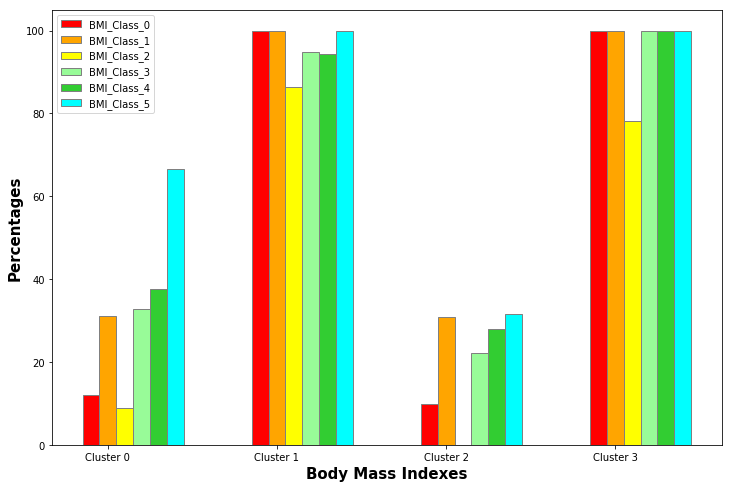

In [60]:
# set width of bar
barWidth = 0.10
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
BMI_Class_0 = df_bmi['BMI_Class_0']
BMI_Class_1 = df_bmi['BMI_Class_1']
BMI_Class_2 = df_bmi['BMI_Class_2']
BMI_Class_3 = df_bmi['BMI_Class_3']
BMI_Class_4 = df_bmi['BMI_Class_4']
BMI_Class_5 = df_bmi['BMI_Class_5']

 # Set position of bar on X axis
br1 = np.arange(len(BMI_Class_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]


# Make the plot
plt.bar(br1, BMI_Class_0, color ='red', width = barWidth,edgecolor ='grey', label ='BMI_Class_0')
plt.bar(br2, BMI_Class_1, color ='orange', width = barWidth,edgecolor ='grey', label ='BMI_Class_1')
plt.bar(br3, BMI_Class_2, color ='yellow', width = barWidth,edgecolor ='grey', label ='BMI_Class_2')
plt.bar(br4, BMI_Class_3, color ='palegreen', width = barWidth,edgecolor ='grey', label ='BMI_Class_3')
plt.bar(br5, BMI_Class_4, color ='limegreen', width = barWidth,edgecolor ='grey', label ='BMI_Class_4')
plt.bar(br6, BMI_Class_5, color ='aqua', width = barWidth,edgecolor ='grey', label ='BMI_Class_5')

 # Adding Xticks
plt.xlabel('Body Mass Indexes', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(BMI_Class_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> BMI Class 2 = Overweight tends to have less CVD
</p></div>

## 4.1.3 Mean Arterial Pressure

In [61]:
df_map.head()

,MAP_Class_0,MAP_Class_1,MAP_Class_2,MAP_Class_3,MAP_Class_4,MAP_Class_5
Cluster 0,12.55,11.94,25.28,19.89,60.13,61.40
Cluster 1,85.71,75.34,100.00,85.49,97.42,95.04
Cluster 2,10.20,10.10,17.03,46.41,59.48,58.67
Cluster 3,70.29,75.49,82.55,94.35,97.17,97.95


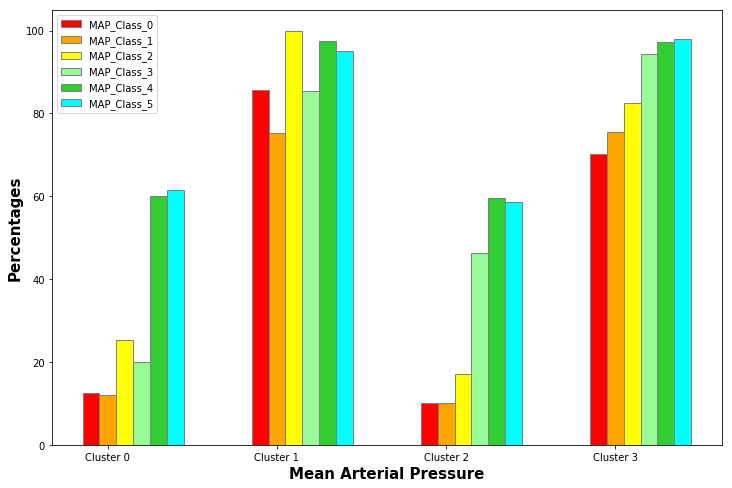

In [62]:
# set width of bar
barWidth = 0.10
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
MAP_Class_0 = df_map['MAP_Class_0']
MAP_Class_1 = df_map['MAP_Class_1']
MAP_Class_2 = df_map['MAP_Class_2']
MAP_Class_3 = df_map['MAP_Class_3']
MAP_Class_4 = df_map['MAP_Class_4']
MAP_Class_5 = df_map['MAP_Class_5']

 # Set position of bar on X axis
br1 = np.arange(len(MAP_Class_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]


# Make the plot
plt.bar(br1, MAP_Class_0, color ='red', width = barWidth,edgecolor ='grey', label ='MAP_Class_0')
plt.bar(br2, MAP_Class_1, color ='orange', width = barWidth,edgecolor ='grey', label ='MAP_Class_1')
plt.bar(br3, MAP_Class_2, color ='yellow', width = barWidth,edgecolor ='grey', label ='MAP_Class_2')
plt.bar(br4, MAP_Class_3, color ='palegreen', width = barWidth,edgecolor ='grey', label ='MAP_Class_3')
plt.bar(br5, MAP_Class_4, color ='limegreen', width = barWidth,edgecolor ='grey', label ='MAP_Class_4')
plt.bar(br6, MAP_Class_5, color ='aqua', width = barWidth,edgecolor ='grey', label ='MAP_Class_5')

 # Adding Xticks
plt.xlabel('Mean Arterial Pressure', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(MAP_Class_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])

plt.legend()
plt.show()

## 4.1.4 Cholesterol

In [63]:
df_chol.head()

,cholesterol_0,cholesterol_1,cholesterol_2
Cluster 0,22.06,29.81,48.41
Cluster 1,89.16,92.40,92.00
Cluster 2,18.84,26.92,44.38
Cluster 3,85.04,90.33,95.20


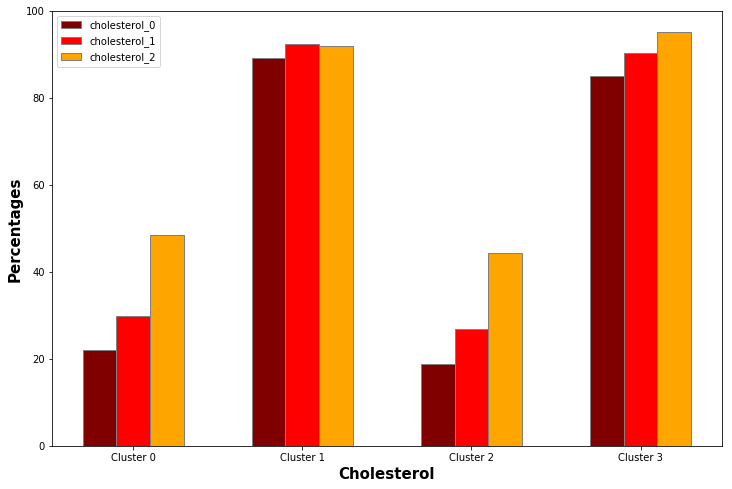

In [64]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
cholesterol_0 = df_chol['cholesterol_0']
cholesterol_1 = df_chol['cholesterol_1']
cholesterol_2 = df_chol['cholesterol_2']
 
# Set position of bar on X axis
br1 = np.arange(len(cholesterol_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, cholesterol_0, color ='maroon', width = barWidth,edgecolor ='grey', label ='cholesterol_0')
plt.bar(br2, cholesterol_1, color ='r', width = barWidth,edgecolor ='grey', label ='cholesterol_1')
plt.bar(br3, cholesterol_2, color ='orange', width = barWidth,edgecolor ='grey', label ='cholesterol_2')
 
# Adding Xticks
plt.xlabel('Cholesterol', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(cholesterol_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> These results are intuitive
</p></div>

## 4.1.5 Glucose

In [65]:
df_gluc.head()

,gluc_0,gluc_1,gluc_2
Cluster 0,23.69,28.45,31.87
Cluster 1,90.18,90.39,89.40
Cluster 2,20.78,24.72,31.12
Cluster 3,86.95,90.59,91.51


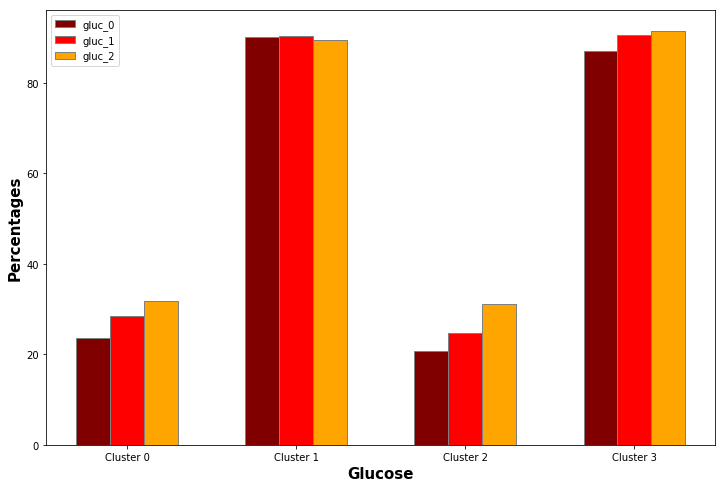

In [66]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
gluc_0 = df_gluc['gluc_0']
gluc_1 = df_gluc['gluc_1']
gluc_2 = df_gluc['gluc_2']
 
# Set position of bar on X axis
br1 = np.arange(len(gluc_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, gluc_0, color ='maroon', width = barWidth,edgecolor ='grey', label ='gluc_0')
plt.bar(br2, gluc_1, color ='r', width = barWidth,edgecolor ='grey', label ='gluc_1')
plt.bar(br3, gluc_2, color ='orange', width = barWidth,edgecolor ='grey', label ='gluc_2')
 
# Adding Xticks
plt.xlabel('Glucose', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(gluc_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> These results are intuitive
</p></div>

## 4.1.6 Smokers

In [67]:
df_smokers.head()

,smoke_0,smoke_1
Cluster 0,25.93,18.90
Cluster 1,90.48,88.86
Cluster 2,21.73,19.49
Cluster 3,87.70,88.43


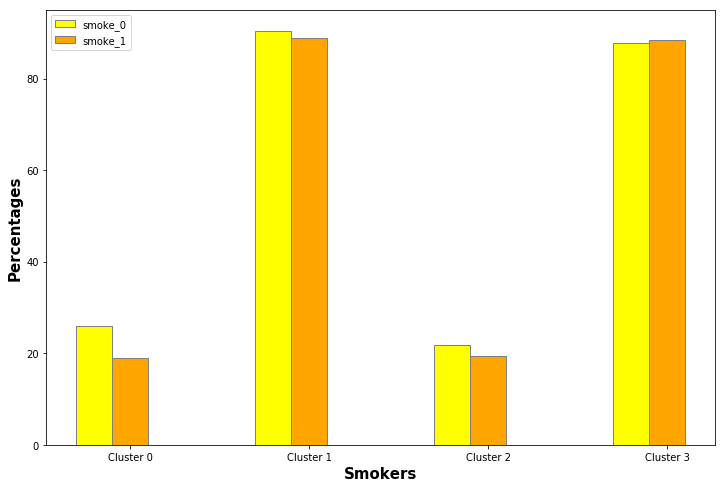

In [68]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
smoke_0 = df_smokers['smoke_0']
smoke_1 = df_smokers['smoke_1']

 # Set position of bar on X axis
br1 = np.arange(len(gluc_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, smoke_0, color ='yellow', width = barWidth,edgecolor ='grey', label ='smoke_0')
plt.bar(br2, smoke_1, color ='orange', width = barWidth,edgecolor ='grey', label ='smoke_1')

# Adding Xticks
plt.xlabel('Smokers', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(smoke_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> These results are counter-intuitive. Non-Smokers tends to have more CVD? 
</p></div>

## 4.1.7 Actives

In [69]:
df_actives.head()

,active_0,active_1
Cluster 0,29.93,23.16
Cluster 1,91.70,89.73
Cluster 2,24.19,21.10
Cluster 3,88.99,87.38


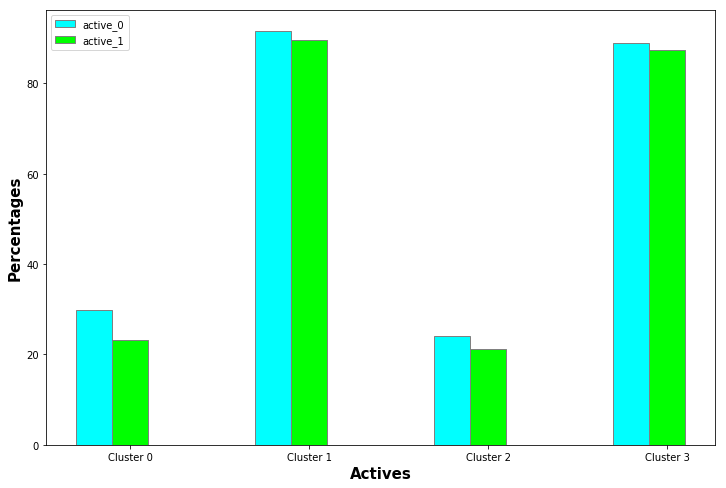

In [70]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
active_0 = df_actives['active_0']
active_1 = df_actives['active_1']

 # Set position of bar on X axis
br1 = np.arange(len(gluc_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, active_0, color ='cyan', width = barWidth,edgecolor ='grey', label ='active_0')
plt.bar(br2, active_1, color ='lime', width = barWidth,edgecolor ='grey', label ='active_1')

# Adding Xticks
plt.xlabel('Actives', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(active_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> These results are counter-intuitive. Non-Active tends to have more CVD? 
</p></div>

# 5.1 Machine Learning

## 5.2 Preprocessing

In [71]:
# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas_profiling as pp

from sklearn.naive_bayes import GaussianNB

In [72]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_ml = df_clusters.apply(le.fit_transform)
df_ml.describe()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.00000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,1.780237,0.347311,4.042233,1.95213,2.237638,0.350953,0.220229,0.085631,0.803648,0.488228
std,1.082721,0.476120,1.377070,0.92357,0.938629,0.670076,0.567607,0.279820,0.397241,0.499866
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,1.00000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,0.000000,4.000000,2.00000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,1.000000,5.000000,2.00000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,1.000000,6.000000,5.00000,5.000000,2.000000,2.000000,1.000000,1.000000,1.000000


In [73]:
target_name = 'cardio'
data_target = df_clusters[target_name]
data = df_clusters.drop([target_name], axis=1)

In [74]:
#separate into 30/70%
train, test, target, target_test = train_test_split(data, data_target, test_size=0.3, random_state=0)

In [75]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.3, random_state=0)

## 5.3 Naive Bayes

In machine learning, Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference Wikipedia.

Thanks to https://www.kaggle.com/vbmokin/20-models-for-cardiovascular-disease-prediction

In [76]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train, target)
acc_gaussian = round(gaussian.score(train, target) * 100, 2)
acc_gaussian

70.46

In [77]:
acc_test_gaussian = round(gaussian.score(test, target_test) * 100, 2)
acc_test_gaussian

70.71

In [78]:
diff_gaussian = acc_gaussian - acc_test_gaussian
diff_gaussian

-0.25

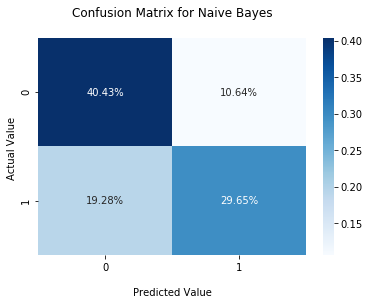

In [79]:
y_pred_gauss = gaussian.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_gauss)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Naive Bayes\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [80]:
print(classification_report(Zval, y_pred_gauss))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      6450
           1       0.74      0.61      0.66      6180

   micro avg       0.70      0.70      0.70     12630
   macro avg       0.71      0.70      0.70     12630
weighted avg       0.71      0.70      0.70     12630



## 5.4 Decision Tree Classifier

In [81]:
from sklearn.tree import DecisionTreeClassifier


In [82]:
# Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
acc_decision_tree = round(decision_tree.score(train, target) * 100, 2)
acc_decision_tree

87.42

In [83]:
acc_test_decision_tree = round(decision_tree.score(test, target_test) * 100, 2)
acc_test_decision_tree

86.27

In [84]:
diff_decision_tree = acc_decision_tree - acc_test_decision_tree
diff_decision_tree

1.1500000000000057

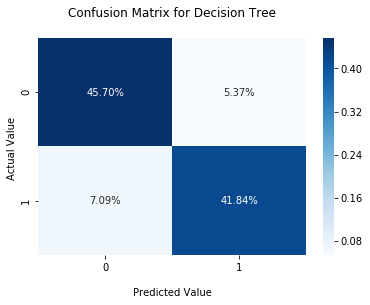

In [85]:
y_pred_dt = decision_tree.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_dt)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Decision Tree\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [86]:
print(classification_report(Zval, y_pred_dt))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6450
           1       0.89      0.86      0.87      6180

   micro avg       0.88      0.88      0.88     12630
   macro avg       0.88      0.88      0.88     12630
weighted avg       0.88      0.88      0.88     12630



## 5.5 Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [88]:
# Random Forest

random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [100, 300]}, cv=5).fit(train, target)
random_forest.fit(train, target)
acc_random_forest = round(random_forest.score(train, target) * 100, 2)
print(acc_random_forest,random_forest.best_params_)

87.42 {'n_estimators': 100}


In [89]:
acc_test_random_forest = round(random_forest.score(test, target_test) * 100, 2)
acc_test_random_forest

86.58

In [90]:
diff_random_forest = acc_random_forest - acc_test_random_forest
diff_random_forest

0.8400000000000034

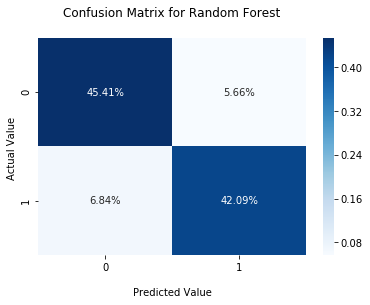

In [91]:
y_pred_df = random_forest.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_df)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Random Forest\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [92]:
print(classification_report(Zval, y_pred_df))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6450
           1       0.88      0.86      0.87      6180

   micro avg       0.87      0.87      0.87     12630
   macro avg       0.88      0.87      0.87     12630
weighted avg       0.88      0.87      0.87     12630



## 5.5 Logistic Regression

In [93]:
from sklearn.linear_model import LogisticRegression

In [94]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train, target)
acc_log = round(logreg.score(train, target) * 100, 2)
acc_log

82.74

In [95]:
acc_test_log = round(logreg.score(test, target_test) * 100, 2)
acc_test_log

83.04

In [96]:
diff_log = acc_log - acc_test_log
diff_log

-0.30000000000001137

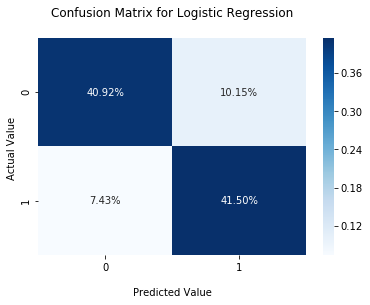

In [97]:
y_pred_lr = logreg.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_lr)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Logistic Regression\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [98]:
print(classification_report(Zval, y_pred_lr))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      6450
           1       0.80      0.85      0.83      6180

   micro avg       0.82      0.82      0.82     12630
   macro avg       0.82      0.82      0.82     12630
weighted avg       0.83      0.82      0.82     12630



# 6. Results for Machine Learning Algorithms



In [99]:
# printing the results
print("precision for Naive Bayes is {0:.2f}% and difference for test and training was {1:.2f}". format(acc_test_gaussian,diff_gaussian))
print("precision for Decision Tree is {0:.2f}% and difference for test and training was {1:.2f}". format(acc_test_decision_tree,diff_decision_tree))
print("precision for Random Forest is {0:.2f}% and difference for test and training was {1:.2f}". format(acc_test_random_forest,diff_random_forest))
print("precision for Logistic Regression is {0:.2f}% and difference for test and training was {1:.2f}". format(acc_test_log,diff_log))

precision for Naive Bayes is 70.71% and difference for test and training was -0.25
precision for Decision Tree is 86.27% and difference for test and training was 1.15
precision for Random Forest is 86.58% and difference for test and training was 0.84
precision for Logistic Regression is 83.04% and difference for test and training was -0.30


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> According to the algorithms used, the Random Forest was the most accurate to classify the data. 
</p></div>

# 7. Final Considerations

I will use a similar analysis on other datasets to see if I find similar results;
The data reported in Smoke, Active and Gluc could have more categories, possibly improving the analysis;
After doing other analysis I will put the links here.

**PLEASE VOTE UP!** 📈

